# Model selection: fit to neural cell types

In the current notebook, we run the MCMC inference pipeline on two pre-clustered mouse brain cell datasets, disaggregated into GABAergic and glutamatergic cell types, using a common set of 1319 genes and four models (bursty, extrinsic, delayed-splicing, and delayed-efflux).

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [3]:
dataset_meta = ['B08','A02']

cluster_names = ['Glutamatergic','GABAergic']
dataset_names = ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names]

transcriptome_filepath = '../seq-cme-technoise/polyA_ref/gg_200524_mouse_genome_polyA_cum_1'
attribute_names=[('unspliced','spliced'),'gene_name','barcode']



In [4]:
loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/allen_'+dataset_meta[0]+'_raw.loom' ]*len(cluster_names) + \
                 ['/home/ggorin/count_data/loom_allen_kb/allen_'+dataset_meta[1]+'_raw.loom' ]*len(cluster_names) 


In [5]:
loom_filepaths

['/home/ggorin/count_data/loom_allen_kb/allen_B08_raw.loom',
 '/home/ggorin/count_data/loom_allen_kb/allen_B08_raw.loom',
 '/home/ggorin/count_data/loom_allen_kb/allen_A02_raw.loom',
 '/home/ggorin/count_data/loom_allen_kb/allen_A02_raw.loom']

In [6]:
n_datasets = len(loom_filepaths)

## Filtering

### Import metadata

In [7]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy

In [8]:
spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'
def knee_plot(S,n_cells,ax1,thr=None,viz=False):
    umi_sum = S.sum(0)
    umi_rank = np.argsort(umi_sum)
    usf = np.flip(umi_sum[umi_rank])
    if viz:
        ax1.plot(np.arange(n_cells),usf,'k')
        ax1.set_xlabel('Cell rank')
        ax1.set_ylabel('UMI count+1')
        ax1.set_yscale('log')
    if thr is not None:
        cf = umi_sum>thr
        rank_ = np.argmin(np.abs(usf-thr))
        if viz:
            ax1.plot([0,n_cells+1],thr*np.ones(2),'r--')
            ys = ax1.get_ylim()
            ax1.plot(rank_*np.ones(2),ys,'r--')
        return cf

10975
10035


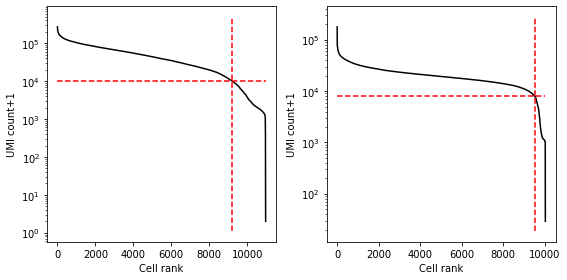

In [9]:
cf = []
thr_lb = [1e4, 8e3]
# thr_ub = [2e5, 1e5]

fig1,ax1 = plt.subplots(1,2,figsize=(8,4))

annot_names = ('sc','sn')
for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(cluster_names)*k]
    
    allen_membership = pd.read_csv(f'~/count_data/allen_metadata/{annot_names[k]}/cluster.membership.csv',skiprows = 1, names=['barcode','cluster_id'])
    allen_annot = pd.read_csv(f'~/count_data/allen_metadata/{annot_names[k]}/cluster.annotation.csv')
    allen_membership['cell_barcode'] = allen_membership['barcode'].str[:16]
    allen_membership['sample'] = allen_membership['barcode'].str[-3:]
    allen_membership['cluster_id'] = allen_membership['cluster_id'].astype("category")
    allen_annot.set_index('cluster_id',inplace=True)
    allen_annot_bc = allen_annot.loc[allen_membership['cluster_id']][['cluster_label','subclass_label','class_label']].set_index(allen_membership.index)
    meta = pd.concat((allen_membership,allen_annot_bc),axis=1)
    omitted_subtypes = ('Sncg','L6 IT Car3')
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        print(len(bcs))
        knee_plot(S+U,n_cells,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        for cluster in cluster_names:
            cf.append(np.isin(bcs,meta[(meta['sample']==dataset_meta[k]) \
                                       & (meta['class_label']==cluster) \
                                       & ~(meta['subclass_label'].isin(omitted_subtypes))]['cell_barcode'])\
                      & cf_)
fig1.tight_layout()

In [10]:
[x.sum() for x in cf]

[5352, 789, 6731, 1253]

## Preprocessing

Construct a batch by finding genes which have at least moderate expression across all datasets. Visualize the set of genes (purple) that meet the expression filtering criteria. Allen data are pretty high-quality, so we have fairly high thresholds.

In [15]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230620_026_allen_1 already exists.
INFO:root:Dataset: allen_B08_Glutamatergic
INFO:root:5352 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:7176 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic already exists.
INFO:root:Dataset: allen_B08_GABAergic
INFO:root:789 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:5891 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230620_026_allen_1/allen_B08_GABAergic already exists.
INFO:root:Dataset: allen_A02_Glutamatergic
INFO:root:6731 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:3056 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230620_026_allen_1/allen_A02_Glutamat

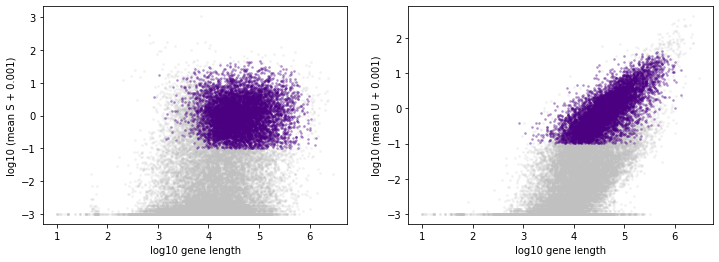

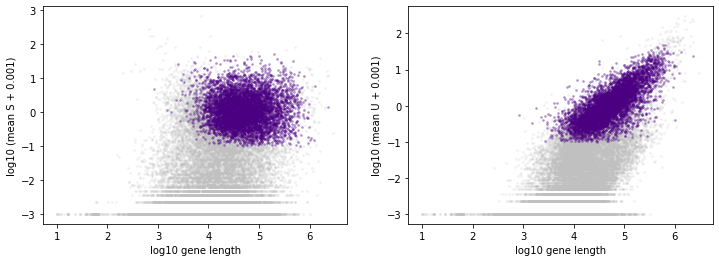

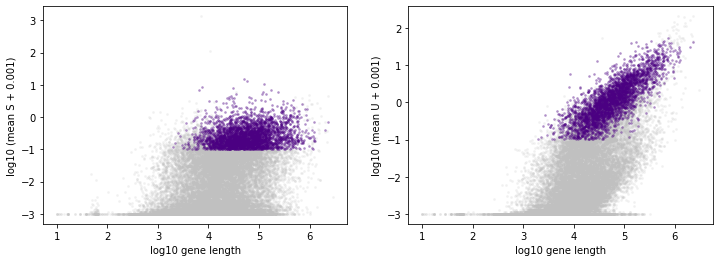

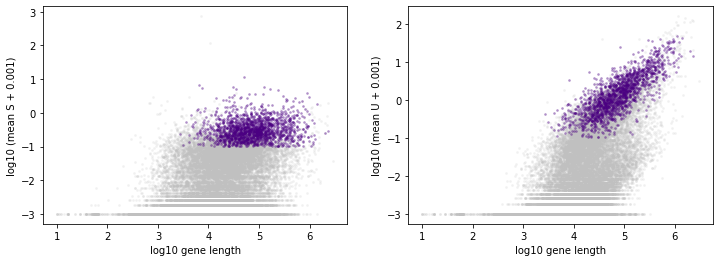

In [17]:

filt_param={
    "min_U_mean": 0.1,
    "min_S_mean": 0.1,
    "max_U_max": 200,
    "max_S_max": 200,
    "min_U_max": 3,
    "min_S_max": 3,}
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='allen',batch_id=1,\
                                             n_genes=2000,exp_filter_threshold=1,cf=cf,
                                             filt_param=filt_param)

INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_Glutamatergic
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_230620_026_allen_1/genes.csv.
INFO:root:Directory ./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_GABAergic
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_230620_026_allen_1/genes.csv.
INFO:root:Directory ./fits/gg_230620_026_allen_1/allen_B08_GABAergic/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230620_026_allen_1/allen_B08_GABAergic/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_A02_Glutamatergic
INFO:root:32285 features observed, 32005 match g

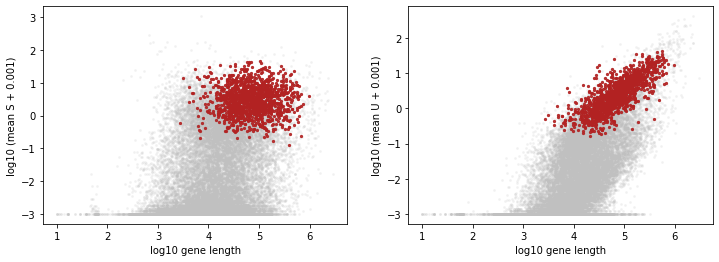

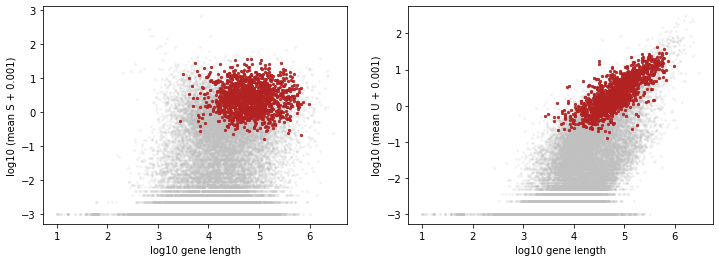

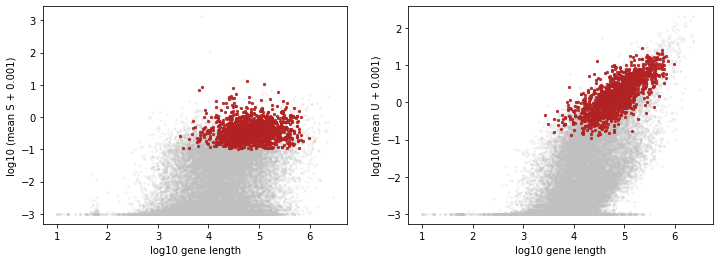

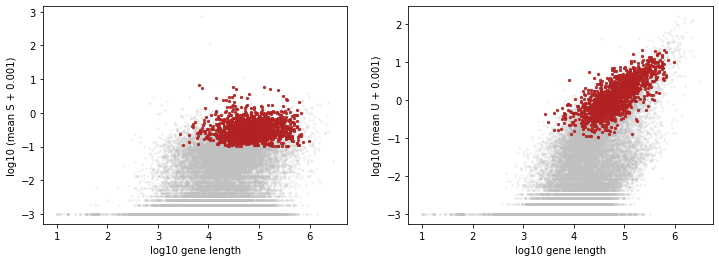

In [18]:
for i in range(n_datasets):
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])


## Inference

In [19]:
import pymc3 as pm
import theano.tensor as tt
import time
import os
import pickle
import tqdm
from tqdm import tqdm

/home/ggorin/miniconda3/lib/python3.9/site-packages/theano/scalar/basic.py:2412: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.ctor = getattr(np, o_type.dtype)
<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject
/home/ggorin/miniconda3/lib/python3.9/site-packages/arviz/__init__.py:317: PendingDeprecationWarning: The register_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps.register(name)`` instead.
  register_cmap("cet_" + name, cmap=cmap)
/home/ggorin/miniconda3/lib/python3.9/site-packages/theano/tensor/basic.py:369: De

In [20]:
dir_string

'./fits/gg_230620_026_allen_1'

In [21]:
dataset_strings

['./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic',
 './fits/gg_230620_026_allen_1/allen_B08_GABAergic',
 './fits/gg_230620_026_allen_1/allen_A02_Glutamatergic',
 './fits/gg_230620_026_allen_1/allen_A02_GABAergic']

In [22]:
dir_string='./fits/gg_230620_026_allen_1'

In [23]:
dataset_strings=['./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic',
 './fits/gg_230620_026_allen_1/allen_B08_GABAergic',
 './fits/gg_230620_026_allen_1/allen_A02_Glutamatergic',
 './fits/gg_230620_026_allen_1/allen_A02_GABAergic']


In [24]:
class LogLike(tt.Op):
    
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)
    
    def __init__(self, mx, data, likelihood,n_cells):
        
        # add inputs as class attributes
        self.mx = mx
        self.data = data
        self.likelihood = likelihood
        self.n_cells = n_cells
        
    def perform(self, node, inputs, outputs):
        
        phi, = inputs # this contains parmeters
        logl = self.likelihood(phi, self.mx, self.data,self.n_cells) # calls the log-likelihood function
        outputs[0][0] = np.array(logl) # output the log-likelihood


In [42]:
def get_parameter_posteriors_smc(string_ID, mx, data, n_cells, ll_func, draws_=1000, chains_=1, cores_=1):
    """"Arguments changed for sample_smc function. Here is pymc3 3.8"""
    # Define log likelihood
    logl_op = LogLike(mx, data, ll_func, n_cells)
    def logl_fun(phi):
        return logl_op(phi)
    
    # Define PyMC3 model
    model = pm.Model()
    with model:
        phi = tt.as_tensor_variable([pm.Uniform(par_names[j], lower=phys_lb[j], upper=phys_ub[j]) for j in range(fitmodel.get_num_params())])
        pm.Potential('likelihood', logl_fun(phi))
        
        
    # Run PyMC3 model
    start_time = time.time()
    with model:
        trace = pm.sample_smc(draws = draws_, chains = chains_, cores = cores_)
#     print("--- %s seconds ---" % (time.time() - start_time))        
    return trace

def ll_bursty(p, mx, data,n_cells):
    return fitmodel.eval_model_logL(p,mx,None,data,n_cells)
def ll_extrinsic(p, mx, data,n_cells):
    return fitmodel.eval_model_logL(p,mx,None,data,n_cells)
def ll_delay(p, mx, data,n_cells):
    return fitmodel.eval_model_logL(p,mx,None,data,n_cells)
def ll_delayedsplicing(p, mx, data,n_cells):
    return fitmodel.eval_model_logL(p,mx,None,data,n_cells)

def smc_wrapper(Input):
    data, mx, n_cells, gene_index, model = Input
#     d_N, d_M = data
#     mx = [np.max(d_N)+10,np.max(d_M)+10]
    if model=='bursty':
        trace_id = 'bursty_'+str(gene_index)
        trace = get_parameter_posteriors_smc(trace_id, mx, data, n_cells, ll_func=ll_bursty, chains_=1, cores_=1)
    if model=='extrinsic':
        trace_id = 'extrinsic_'+str(gene_index)
        trace = get_parameter_posteriors_smc(trace_id, mx, data, n_cells, ll_func=ll_extrinsic, chains_=1, cores_=1)
    if model=='delay':
        trace_id = 'delay_'+str(gene_index)
        trace = get_parameter_posteriors_smc(trace_id, mx, data, n_cells, ll_func=ll_delay, chains_=1, cores_=1)
    if model=='delayedsplicing':
        trace_id = 'delayedsplicing_'+str(gene_index)
        trace = get_parameter_posteriors_smc(trace_id, mx, data, n_cells, ll_func=ll_delayedsplicing, chains_=1, cores_=1)
    smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'

    with open(smc_path+'/'+trace_id+'.pickle', 'wb') as f:
        
        pickle.dump(trace, f)
    return trace

# Bursty

In [26]:

model = 'bursty'
fitmodel = monod.cme_toolbox.CMEModel('Bursty','None')
phys_lb = [-2.0, -1.8, -1.8]
phys_ub = [3.1, 3.5, 3.5]
phys_lb=np.asarray(phys_lb)
phys_ub=np.asarray(phys_ub)
par_names = ['b','beta','gamma']


In [27]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


In [30]:
num_cores = 50
log = logging.getLogger()
log.setLevel(logging.WARNING)

Get dataset

In [31]:
dataset_ind = 0
sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
n_genes = sd.n_genes
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
os.makedirs(smc_path,exist_ok=True)
entries = range(n_genes)
iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
    pickle.dump(par_results, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [1:57:09<00:00,  5.33s/it]


In [32]:
dataset_ind = 1
sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
os.makedirs(smc_path,exist_ok=True)
entries = range(n_genes)
iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
    pickle.dump(par_results, f)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [1:05:20<00:00,  2.97s/it]


In [33]:
dataset_ind = 2
sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
os.makedirs(smc_path,exist_ok=True)
entries = range(n_genes)
iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
    pickle.dump(par_results, f)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [28:19<00:00,  1.29s/it]


In [34]:
dataset_ind = 3
sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
os.makedirs(smc_path,exist_ok=True)
entries = range(n_genes)
iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
    pickle.dump(par_results, f)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [22:54<00:00,  1.04s/it]


# Extrinsic

In [37]:

model = 'extrinsic'
fitmodel = monod.cme_toolbox.CMEModel('Extrinsic','None')
phys_lb = [-2.0, -1.8, -1.8]
phys_ub = [3.1, 3.5, 3.5]
phys_lb=np.asarray(phys_lb)
phys_ub=np.asarray(phys_ub)
par_names = ['alpha','beta','gamma']


In [38]:
dataset_ind = 0
sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
n_genes = sd.n_genes
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
os.makedirs(smc_path,exist_ok=True)
entries = range(n_genes)
iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
    pickle.dump(par_results, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [26:03<00:00,  1.19s/it]


In [39]:
dataset_ind = 1
sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
n_genes = sd.n_genes
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
os.makedirs(smc_path,exist_ok=True)
entries = range(n_genes)
iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
    pickle.dump(par_results, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [17:26<00:00,  1.26it/s]


In [40]:
dataset_ind = 2
sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
n_genes = sd.n_genes
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
os.makedirs(smc_path,exist_ok=True)
entries = range(n_genes)
iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
    pickle.dump(par_results, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [12:46<00:00,  1.72it/s]


In [41]:
dataset_ind = 3
sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
n_genes = sd.n_genes
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
os.makedirs(smc_path,exist_ok=True)
entries = range(n_genes)
iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
    pickle.dump(par_results, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [10:45<00:00,  2.04it/s]


# Delayed export

In [44]:

model = 'delay'
fitmodel = monod.cme_toolbox.CMEModel('Delay','None')
phys_lb = [-2.0, -1.8, -1.8]
phys_ub = [3.1, 3.5, 3.5]
phys_lb=np.asarray(phys_lb)
phys_ub=np.asarray(phys_ub)
par_names = ['alpha','beta','tauinv']

for dataset_ind in range(4):
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
    n_genes = sd.n_genes
    smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
    os.makedirs(smc_path,exist_ok=True)
    entries = range(n_genes)
    iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
    par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
    with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
        pickle.dump(par_results, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [12:31<00:00,  1.75it/s]


# Delayed splicing

In [45]:

model = 'delayedsplicing'
fitmodel = monod.cme_toolbox.CMEModel('DelayedSplicing','None')
phys_lb = [-2.0, -1.8, -1.8]
phys_ub = [3.1, 3.5, 3.5]
phys_lb=np.asarray(phys_lb)
phys_ub=np.asarray(phys_ub)
par_names = ['alpha','tauinv','gamma']

for dataset_ind in range(4):
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
    n_genes = sd.n_genes
    smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
    os.makedirs(smc_path,exist_ok=True)
    entries = range(n_genes)
    iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
    par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
    with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
        pickle.dump(par_results, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [10:27<00:00,  2.10it/s]


# Move results around

In [46]:
import shutil


In [53]:
result_dir = './fits/smc_fits/'
os.makedirs(result_dir,exist_ok=True)
for dataset_ind in range(4):
    dataset_result_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results/'
    for model in ['bursty','extrinsic','delay','delayedsplicing']:
        dataset_result_file_path = dataset_result_path + model+'_all.pickle'
        destination = result_dir + dataset_names[dataset_ind]+'_'+model+'.pickle'
        print(dataset_result_file_path)
        print(destination)
        print('---')
        shutil.copy(dataset_result_file_path, destination)


./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic/smc_results/bursty_all.pickle
./fits/smc_fits/allen_B08_Glutamatergic_bursty.pickle
---
./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic/smc_results/extrinsic_all.pickle
./fits/smc_fits/allen_B08_Glutamatergic_extrinsic.pickle
---
./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic/smc_results/delay_all.pickle
./fits/smc_fits/allen_B08_Glutamatergic_delay.pickle
---
./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic/smc_results/delayedsplicing_all.pickle
./fits/smc_fits/allen_B08_Glutamatergic_delayedsplicing.pickle
---
./fits/gg_230620_026_allen_1/allen_B08_GABAergic/smc_results/bursty_all.pickle
./fits/smc_fits/allen_B08_GABAergic_bursty.pickle
---
./fits/gg_230620_026_allen_1/allen_B08_GABAergic/smc_results/extrinsic_all.pickle
./fits/smc_fits/allen_B08_GABAergic_extrinsic.pickle
---
./fits/gg_230620_026_allen_1/allen_B08_GABAergic/smc_results/delay_all.pickle
./fits/smc_fits/allen_B08_GABAergic_delay.pickle
---
./fits/gg_2